In [61]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import re
import gensim
import collections
import pyarabic.araby as araby
from nltk import ngrams

In [2]:
import matplotlib.pyplot as plt
from tqdm import tqdm

# Data
### Helping Functions

In [3]:
def normalization(t):
    t = araby.strip_tashkeel(t)
    t = araby.normalize_hamza(t)
    t = araby.normalize_alef(t)
    t = araby.strip_tatweel(t)
    t = araby.normalize_teh(t)
    t = re.sub("ى","ي",t)
    return t

### Data

In [4]:
data= np.load('../translation project/AD_NMT-master/LAV-MSA-2-both.pkl',allow_pickle=True)

In [5]:
data[0] # lav , msa

['لا انا بعرف وحدة راحت ع فرنسا و معا شنتا حطت فيها الفرش',
 'لا اعرف واحدة ذهبت الى فرنسا و لها غرفة و ضعت فيها الافرشة']

In [6]:
# extract only msa text
msa=[]
for i,ex in enumerate(data):
    msa_text = normalization(ex[1])
    data[i][1] = msa_text
    msa.append(msa_text)

In [7]:
msa = ' '.join(msa)

Dictionaries

In [8]:
msa_d=collections.Counter(msa.split())

In [9]:
min_count = 2

In [10]:
idx2msa = np.array([word for word,freq in msa_d.items() if freq > min_count ])

In [11]:
msa2idx = {word:i for i,word in enumerate(idx2msa)}

In [12]:
msa_data = [' '.join([i for i in t[1].split() if (msa2idx.get(i,-1) != -1 and t[1] != '')]) for t in data]

In [13]:
msa_data = [i for i in msa_data if i != '']

In [14]:
lengths = [len(i) for i in msa.split()]

(array([4.8950e+03, 1.9324e+04, 0.0000e+00, 2.4495e+04, 0.0000e+00,
        2.6011e+04, 2.0113e+04, 0.0000e+00, 1.1975e+04, 0.0000e+00,
        6.5210e+03, 1.9170e+03, 0.0000e+00, 4.9600e+02, 0.0000e+00,
        2.2600e+02, 6.2000e+01, 0.0000e+00, 1.1000e+01, 5.0000e+00]),
 array([ 1. ,  1.6,  2.2,  2.8,  3.4,  4. ,  4.6,  5.2,  5.8,  6.4,  7. ,
         7.6,  8.2,  8.8,  9.4, 10. , 10.6, 11.2, 11.8, 12.4, 13. ]),
 <BarContainer object of 20 artists>)

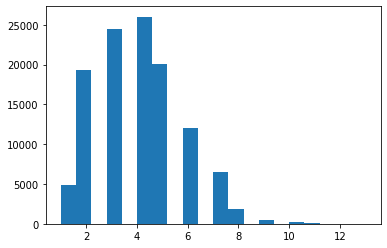

In [15]:
plt.hist(lengths,bins=20)

Load Embeddings

In [16]:
t_model = gensim.models.Word2Vec.load('../resources/models/word vectors/word2vec/wiki/full_grams_cbow_100_wiki/full_grams_cbow_100_wiki.mdl')

In [17]:
i2l = list(set(normalization(araby.LETTERS)))
i2v = {}
for index,letter in enumerate(i2l):
    if letter in t_model.wv.index_to_key :
        i2v[index] = t_model.wv.get_vector(letter)

In [18]:
i2l.append(' ')#Space
i2l.append('s')#eos
i2l.append('E')#Empty
i2l.append('L')#left pad
i2l.append('R')#right pad
i2l.append('X')#UNK
i2l.append('P')#pad

In [19]:
l2i = {v:i for i,v in enumerate(i2l)}

In [20]:
len(i2l)

36

## ALL in Model

In [21]:
from torch.utils.data import Dataset,DataLoader

In [22]:
from torch.nn.utils.rnn import pad_sequence 

In [23]:
def noise(txt):
    sz = 2#int(len(txt)*0.2)
    noise_sz = np.random.randint(0,sz if sz>1 else 1,1)
    replace_idx = np.random.choice(len(txt),noise_sz,replace=False)
    letters_idx = np.random.choice(len(i2l)-3,noise_sz,replace=True)
    txt = list(txt)
    for rep,let in zip(replace_idx,letters_idx):
        txt[rep] = i2l[let]
    return ''.join(txt)

In [24]:
class arrDs(Dataset):
    def __init__(self,txt_list,l2i):
        self.data = txt_list
        self.l2i = l2i
    def __len__(self):
        return len(self.data)
    def __getitem__(self,idx):
        X = noise(self.data[idx])
        Y = self.data[idx]
        
        X = torch.tensor([self.l2i.get(i,31) for i in X])
        Y = torch.tensor([self.l2i.get(i,31) for i in Y])
        #numerilize
        return (X,Y)

In [31]:
trn_data, val_data = msa_grams[:int(0.8*len(msa_grams))],msa_grams[int(0.8*len(msa_grams)):]

In [32]:
trn_ds,val_ds = arrDs(trn_data,l2i),arrDs(val_data,l2i)

In [33]:
def collate_fn(data):
    label  = [i for _,i in data]
    label = pad_sequence(label,batch_first=True,padding_value=l2i['P'])
    data = [i for i,_ in data]
    data = pad_sequence(data,batch_first=True,padding_value=l2i['P'])
    return data,label

In [34]:
trn_dl = DataLoader(trn_ds,batch_size=512,collate_fn=collate_fn,drop_last=False,shuffle=True)
val_dl = DataLoader(val_ds,batch_size=512,collate_fn=collate_fn,drop_last=False)

Model

In [35]:
import torch, torch.nn as nn

In [36]:
class autocorrect(nn.Module):
    def __init__(self,num_emb,vs,hs,bidirectional=True):
        super().__init__()
        self.emb = nn.Embedding(num_emb,vs)
        self.gru = nn.GRU(vs,hs,num_layers=3,bidirectional=bidirectional,batch_first=True,dropout=0.2)
        self.lin = nn.Sequential(nn.Linear(2*hs if bidirectional == True else hs,hs),
                                 nn.ReLU(),
                                 nn.Linear(hs,num_emb))
    def forward(self,x):
        bs,seq_len=x.shape
        x = torch.relu(self.emb(x))
        x,_ = self.gru(x)
        x = nn.functional.relu(x)
        x = self.lin(x)
        return torch.log_softmax(x,dim=-1).view(bs*seq_len,-1)

In [37]:
num_emb = len(i2l)

In [38]:
model = autocorrect(num_emb,100,512).cuda()

In [39]:
#Load available vectors
model.emb.weight.requires_grad_(False)
for i in i2v.keys():
    model.emb.weight[i] = nn.Parameter(torch.from_numpy(i2v[i].copy())).requires_grad_(False)
model.emb.weight.requires_grad_(True);

In [40]:
opt = torch.optim.Adam(model.parameters(),lr=1e-3)

In [41]:
loss = nn.CrossEntropyLoss(ignore_index=l2i['P'])

In [45]:
def train(epoch,model,trn_dl,val_dl,loss_fnc):
    model.train()
    for i in range(epoch):
        model.train()
        for batch in tqdm.tqdm(trn_dl,desc='train'):
            opt.zero_grad()
            ip,label = batch
            op = model(ip.cuda())
            trn_l = loss_fnc(op,label.view(-1).cuda())
            trn_l.backward()
            opt.step()
        
        with torch.no_grad():
            model.eval()
            for batch in tqdm.tqdm(val_dl,desc='validation'):
                ip,label = batch
                op = model(ip.cuda())
                val_loss = loss_fnc(op,label.view(-1).cuda())
        print('train_loss ->',trn_l.item() , 'val_loss ->',val_loss.item())

In [46]:
train(4,model,trn_dl,val_dl,loss)

validation: 100%|██████████| 181/181 [00:09<00:00, 19.22it/s]


train_loss -> 0.20039041340351105 val_loss -> 0.1697191298007965


validation: 100%|██████████| 181/181 [00:09<00:00, 19.57it/s]


train_loss -> 0.1858951300382614 val_loss -> 0.11031968891620636


validation: 100%|██████████| 181/181 [00:09<00:00, 19.49it/s]


train_loss -> 0.16917631030082703 val_loss -> 0.12228929996490479


validation: 100%|██████████| 181/181 [00:09<00:00, 19.40it/s]

train_loss -> 0.15981334447860718 val_loss -> 0.07429787516593933


In [ ]:
ip,label = batch
op = model(ip.cuda())
val_loss = loss_fnc(op.argmax(dim=-1),label.view(-1).cuda())

In [57]:
op.view(512,-1,36).shape

torch.Size([512, 8, 36])

In [69]:
t=0
total=0
for batch in tqdm.tqdm(val_dl,desc='validation'):
    ip,label = batch
    op = model(ip.cuda())
    t += ((op.argmax(dim=-1).view(-1,8) == label.cuda()).sum(dim=-1)//8).sum().data
    total +=  label.shape[0]

validation: 100%|██████████| 181/181 [00:09<00:00, 19.50it/s]


In [71]:
t/total

tensor(0.7282, device='cuda:0')

# Seq to Seq

In [21]:
from torch.utils.data import Dataset,DataLoader
import tqdm
import random

In [22]:
def get_ngrams(txt,ws=7):
    ignore = ws-3
    txt = list(txt)
    grams = ngrams(txt,ws ,pad_left=True,pad_right=True,left_pad_symbol='L',right_pad_symbol='R')
    grams = [list(i)+['R'] for i in grams]
    return list(grams)[ignore:-ignore]

In [23]:
msa_grams=[]
for txt in msa_data:
    ng = get_ngrams(txt)
    if ng:
        msa_grams.extend(ng)

In [24]:
def noise(txt):
    sz = 2 #int(len(txt)*0.2)
    noise_sz = np.random.randint(0,sz if sz>1 else 1,1)
    replace_idx = np.random.choice(len(txt),noise_sz,replace=False)
    letters_idx = np.random.choice(len(i2l)-3,noise_sz,replace=True)
    txt = list(txt)
    for rep,let in zip(replace_idx,letters_idx):
        txt[rep] = i2l[let]
    return ''.join(txt)

In [25]:
class arrDs(Dataset):
    def __init__(self,txt_list,l2i):
        self.data = txt_list
        self.l2i = l2i
    def __len__(self):
        return len(self.data)
    def __getitem__(self,idx):
        X = noise(self.data[idx])
        Y = self.data[idx]
        
        X = torch.tensor([self.l2i.get(i,l2i['X']) for i in X])
        Y = torch.tensor([self.l2i.get(i,l2i['X']) for i in Y])
        #numerilize
        return torch.stack([X,Y])

In [26]:
part_msa_grams = msa_grams[:int(len(msa_grams)*0.1)]

In [27]:
trn_data, val_data = part_msa_grams[:int(0.8*len(part_msa_grams))],part_msa_grams[int(0.8*len(part_msa_grams)):]

In [28]:
trn_ds,val_ds = arrDs(trn_data,l2i),arrDs(val_data,l2i)

In [29]:
trn_dl = DataLoader(trn_ds,batch_size=256,drop_last=False,shuffle=True)
val_dl = DataLoader(val_ds,batch_size=256,drop_last=False,shuffle=True)

Model

In [30]:
import torch, torch.nn as nn

In [31]:
class AC_ENC(nn.Module):
    def __init__(self,num_emb,vs,hs,num_layers=1,dp=0.0,bidirectional=True):
        '''Autocorrect encoder
        num emb : vocab size
        vs: vector size of the embeddings
        hs: hidden size of RNNs
        num_layers: number of layers
        '''
        super().__init__()
        self.hs = hs
        self.emb = nn.Embedding(num_emb,vs)
        self.enc_gru = nn.GRU(vs,hs,num_layers=num_layers,dropout=dp,
                              bidirectional=bidirectional,batch_first=True)
    def forward(self,x):
        bs,seq_len=x.shape
        x = self.emb(x)
        x = self.enc_gru(x)
        return x

In [153]:
a = next(iter(trn_dl))

In [160]:
enc = AC_ENC(36,32,32,bidirectional=False,num_layers=1)

In [161]:
enc_op,enc_hidden = enc(a[:,0,:])

In [162]:
class AC_DEC(nn.Module):
    def __init__(self,num_emb,vs,hs,num_layers=1,dp=0.0,bidirectional=False):
        super().__init__()
        self.num_emb = num_emb
        self.emb = nn.Embedding(num_emb,vs)
        self.dec_gru = nn.GRU(vs,hs,num_layers=num_layers,dropout=dp,
                              bidirectional=False,batch_first=True)
        self.unifier = nn.Sequential(nn.Linear(num_layers*(2 if bidirectional==True else 1),num_layers),
                                nn.ReLU()) 
        self.lin = nn.Sequential(nn.Linear(hs,num_emb),
                                nn.LogSoftmax(dim=-1))
    def forward(self,hidden,label=None):
        _,bs,hs=hidden.shape
        op_list=[]
        op_list_prob = []
        hidden = self.unifier(hidden.permute(2,1,0)).permute(2,1,0).contiguous()
        inp = torch.tensor(l2i['L']).repeat(bs,1).cuda()
        for i in range(8):
            op = self.emb(inp)
            op,hidden = self.dec_gru(op,hidden)
            word_prob = self.lin(hidden)
            
            
            if label is not None:
                inp = label[:,i].clone()[:,None]
            else:
                inp = torch.argmax(word_prob,dim=-1)[0].unsqueeze(-1)
            hidden = hidden.detach() 
            op_list_prob.append(word_prob)
            op_list.append(inp.detach())
        
        prob = torch.stack(op_list_prob,dim=1)[-1:].permute(2,0,1,3)#4,15,256,36
        seq = torch.stack(op_list).squeeze(-1).T
        return prob,seq

In [248]:
class AC_DEC_ATTN(nn.Module):
    def __init__(self,num_emb,vs,hs,num_layers=1,dp=0.0,bidirectional=False):
        super().__init__()
        self.num_emb = num_emb
        self.emb = nn.Embedding(num_emb,vs)
        self.dec_gru = nn.GRU(vs,hs,num_layers=num_layers,dropout=dp,
                              bidirectional=False,batch_first=True)
        self.unifier = nn.Sequential(nn.Linear(num_layers*(2 if bidirectional==True else 1),num_layers),
                                nn.ReLU()) 
        self.lin = nn.Sequential(nn.Linear(hs,num_emb),
                                nn.LogSoftmax(dim=-1))
        
        self.attn = nn.Linear(hs * 2, 8)
        self.attn_combine = nn.Linear(hs * 2, hs)
    def forward(self,hidden,enc_outputs,label=None):
        _,bs,hs=hidden.shape
        op_list=[]
        op_list_prob = []
        hidden = self.unifier(hidden.permute(2,1,0)).permute(2,1,0).contiguous()
        inp = torch.tensor(l2i['L']).repeat(bs,1).cuda()
        for i in range(8):
            emb = self.emb(inp)
       
            op = emb.repeat(1,hidden.size(0),1).permute(1,0,2)
            attn = F.softmax(self.attn(torch.cat([op,hidden],dim=-1)),dim=-1).permute(1,0,2)
            #print(attn.shape,enc_outputs.shape)
            attn_applied = torch.bmm(attn,enc_outputs)
            op=F.relu(self.attn_combine(torch.cat([emb,attn_applied],dim=-1)))
            #print('attn_applied',op.shape)
            op,hidden = self.dec_gru(op,hidden)
            #print(op.shape,hidden.shape)
            word_prob = self.lin(hidden)
            
            
            if label is not None:
                inp = label[:,i].clone()[:,None]
            else:
                inp = torch.argmax(word_prob,dim=-1)[0].unsqueeze(-1)
            hidden = hidden.detach() 
            op_list_prob.append(word_prob)
            op_list.append(inp.detach())
        
        prob = torch.stack(op_list_prob,dim=1)[-1:].permute(2,0,1,3)#4,15,256,36
        seq = torch.stack(op_list).squeeze(-1).T
        return prob,seq

In [249]:
dec = AC_DEC_ATTN(36,32,32,bidirectional=False,num_layers=1).cuda()

In [252]:
l = dec(enc_hidden.cuda(),enc_op.cuda(),a[:,1,:].cuda())

In [257]:
class AC(nn.Module):
    def __init__(self,num_emb,vs,hs,num_layers=1,dp=0.0,bidirectional=False):
        super().__init__()
        self.enc = AC_ENC(num_emb,hs,hs,num_layers=num_layers,dp=dp,bidirectional=bidirectional).cuda()
        self.dec = AC_DEC_ATTN(num_emb,hs,hs,num_layers=num_layers,dp=dp,bidirectional=bidirectional).cuda()
    def forward(self,x,label=None):
        enc_op,enc_hidden = self.enc(x)
        dec_prob,dec_seq = self.dec(enc_hidden,enc_op,label)
        return dec_prob.contiguous().view(-1,num_emb),dec_seq

In [258]:
def train(epoch,model,trn_dl,val_dl,loss_fnc):
    model.train()
    for i in range(epoch):
        model.train()
        for batch in tqdm.tqdm(trn_dl,'train'):
            opt.zero_grad()
            ip,label = batch[:,0,:],batch[:,1,:]
            
            tgt = label.clone().cuda() if random.random() > 0.5 else None
            
            op = model(ip.cuda(),tgt)[0]
            trn_l = loss_fnc(op,label.contiguous().view(-1).cuda())
            trn_l.backward()
            opt.step()
        with torch.no_grad():
            model.eval()
            for batch in tqdm.tqdm(val_dl,'validation'):
                ip,label = batch[:,0,:],batch[:,1,:]
                op = model(ip.cuda())[0]
                val_loss = loss_fnc(op,label.contiguous().view(-1).cuda())
        print(f'epoch {i+1} train_loss ->',trn_l.item() , 'val_loss ->',val_loss.item())

In [259]:
num_emb = len(i2l)

In [265]:
model = AC(num_emb,10,512,bidirectional=False,num_layers=1).cuda()

In [266]:
opt = torch.optim.Adam(model.parameters(),lr=1e-4)

In [267]:
loss = nn.CrossEntropyLoss(ignore_index=l2i['P'])

In [268]:
train(5,model,trn_dl,val_dl,loss)

validation: 100%|██████████| 37/37 [00:00<00:00, 41.28it/s]


epoch 1 train_loss -> 1.4358280897140503 val_loss -> 1.7291322946548462


validation: 100%|██████████| 37/37 [00:00<00:00, 41.61it/s]


epoch 2 train_loss -> 0.8792869448661804 val_loss -> 0.5220316052436829


validation: 100%|██████████| 37/37 [00:00<00:00, 40.46it/s]


epoch 3 train_loss -> 0.7479058504104614 val_loss -> 0.7096359133720398


validation: 100%|██████████| 37/37 [00:00<00:00, 40.47it/s]


epoch 4 train_loss -> 0.3371341824531555 val_loss -> 0.24764351546764374


validation: 100%|██████████| 37/37 [00:00<00:00, 40.36it/s]

epoch 5 train_loss -> 0.6555259227752686 val_loss -> 1.0536491870880127


In [269]:
b= iter(val_dl)

In [270]:
a = next(b)

In [271]:
tgt = a[:,1,:].cuda()

In [272]:
op = model(a[:,0,:].cuda())

In [273]:
op[1].shape

torch.Size([256, 8])

In [274]:
c=0
for i,tensor in enumerate(op[1]):
    if (tensor==tgt[i]).sum()/len(tensor) == 1:
        c+=1

In [275]:
c

120

In [276]:
op[1][0]

tensor([18, 18,  7, 29, 27,  0, 28, 33], device='cuda:0')

In [277]:
a[0]

tensor([[18, 18,  7, 29, 27,  0, 28, 33],
        [18,  0,  7, 29, 27,  0, 28, 33]])

In [278]:
tgt[0]

tensor([18,  0,  7, 29, 27,  0, 28, 33], device='cuda:0')